[nltk_data] Downloading package punkt to C:\Users\Jesus De La
[nltk_data]     Fuente\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Jesus De La
[nltk_data]     Fuente\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jesus De La
[nltk_data]     Fuente\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   Unnamed: 0                    id  \
0           0  AVqVGWQDv8e3D1O-ldFr   
1           1  AVqkIhwDv8e3D1O-lebb   
2           2  AVphgVaX1cnluZ0-DR74   
3           3  AVphgVaX1cnluZ0-DR74   
4           4  AVqVGWLKnnc1JgDc3jF1   

                                        reviews.text  reviews.rating  \
0  This is a very nice tablet for my GF who has n...             5.0   
1  Love this tablet. Easy to use. And price was r...             5.0   
2  Affordable price awesome quality I love my Ama...             5.0   
3  I bought this after speaking with a sales rep ...             5.0   
4  Bought this tablet for my 2 &1/2 year old and ...             5.0   

                                    reviews.text_esp  
0  Esta es una tableta muy agradable para mi novi...  
1  Me encanta esta tableta. Fácil de usar. Y el p...  
2  Precio asequible calidad increíble Me encanta ...  
3  Compré esto después de hablar con un represent...  
4  Compré esta tableta para mi hijo de 2 años y m...  
  

[nltk_data] Downloading package stopwords to C:\Users\Jesus De La
[nltk_data]     Fuente\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy de Naive Bayes: 0.6917

Algunas predicciones de Naive Bayes:
Comentario: compré black friday impulso costaba certificado usar ipad tercera generación bastante acostumbrado u... | Sentimiento Real: neutral | Predicción: negativo
Comentario: compré principalmente copia seguridad leer libros teléfono celular grande copia seguridad usé ocasio... | Sentimiento Real: negativo | Predicción: negativo
Comentario: uso principalmente ver películas amazon netflix gran adición hogar... | Sentimiento Real: positivo | Predicción: positivo
Comentario: pude descargar libros casa tres visitas best buy devolví... | Sentimiento Real: negativo | Predicción: negativo
Comentario: decidí quería probar tableta leer libros redes sociales lugar usar teléfono tiempo investigué fire f... | Sentimiento Real: neutral | Predicción: positivo
Comentario: primer día compra sobrecalienta producto defectuoso... | Sentimiento Real: negativo | Predicción: negativo
Comentario: compramos hija años genial mayoría hace

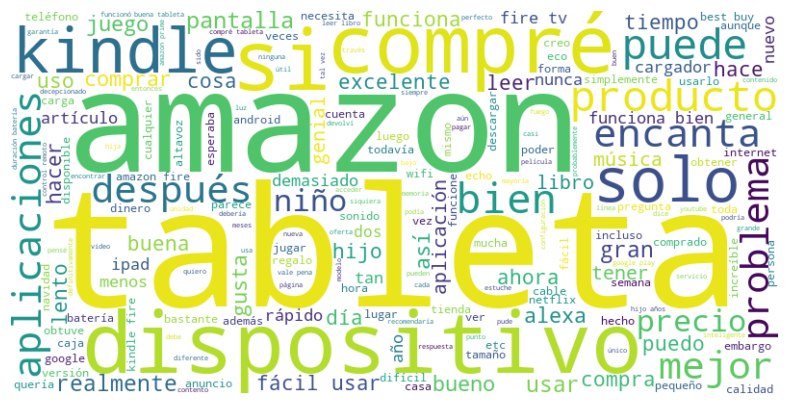

In [26]:
# Falta mejorar los modelos, entremnar con un conjunto mas grande y equilibrar los datos para disminuir el sesgo. Falta paralelizar el preprocesamiento y el modelo
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Cargar dataset desde la URL
url = "https://raw.githubusercontent.com/ignaciomsarmiento/RecomSystemsLectures/main/L07_sentimientos/data/Amazon.csv"
df = pd.read_csv(url)

print(df.head())

# comentarios en español
df = df[['reviews.text_esp', 'reviews.rating']]  

# Eliminar filas con valores nulos
df = df.dropna(subset=['reviews.text_esp', 'reviews.rating'])

# Asignar etiquetas de sentimiento segun la puntuacion:
# 1-2: negativo, 3: neutro, 4-5: positivo, falta equilibrar datos
df['sentimiento'] = df['reviews.rating'].apply(lambda x: 'negativo' if x <= 2 else ('neutral' if x == 3 else 'positivo'))

df = df[df['reviews.text_esp'].apply(lambda x: isinstance(x, str) and len(x.split()) > 3)]  # comentarios con ms de 3 palabras

# Ver las primeras filas del dataset limpio
print(df.head())

# Descargar el conjunto de stopwords en español
nltk.download('stopwords')

# preprocesamiento de texto con eliminacion de stopwords
def preprocesar_texto(texto):
    # Convertir todo a minúsculas
    texto = texto.lower()
    
    # Eliminar caracteres no alfabeticos
    texto = re.sub(r'[^a-záéíóúñ\s]', '', texto)
    
    # Eliminar stopwords en español
    stop_words = set(stopwords.words('spanish'))
    texto = ' '.join([palabra for palabra in texto.split() if palabra not in stop_words])
    
    return texto

# Aplicar preprocesamiento a los comentarios
df['reviews.text_esp'] = df['reviews.text_esp'].apply(preprocesar_texto)

# Dividir el dataset en conjunto de entrenamiento y prueba
X = df['reviews.text_esp']
y = df['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un pipeline con un CountVectorizer y un clasificador Naive Bayes
pipeline = make_pipeline(CountVectorizer(), MultinomialNB())

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy de Naive Bayes: {accuracy:.4f}')

# Mostrar algunos resultados de prediccion
print("\nAlgunas predicciones de Naive Bayes:")
for text, true_label, pred_label in zip(X_test[:10], y_test[:10], y_pred[:10]):
    print(f"Comentario: {text[:100]}... | Sentimiento Real: {true_label} | Predicción: {pred_label}")

# Dividir el dataset en conjunto de entrenamiento y prueba para Naive Bayes manual
train_texts, test_texts, train_labels, test_labels = train_test_split(df['reviews.text_esp'], df['sentimiento'], test_size=0.2, random_state=42)

# Crear un conjunto de características (features)
def extraer_caracteristicas(texto):
    return {palabra: True for palabra in texto.split()}  # Caracteristicas: palabras presentes en el texto

# Crear el conjunto de entrenamiento y prueba
train_features = [(extraer_caracteristicas(texto), label) for texto, label in zip(train_texts, train_labels)]
test_features = [(extraer_caracteristicas(texto), label) for texto, label in zip(test_texts, test_labels)]

# Entrenar el clasificador Naive Bayes manual
classifier = NaiveBayesClassifier.train(train_features)


# Caractersticas más informativas de Naive Bayes
print("\nCaracterísticas más informativas de Naive Bayes:")
classifier.show_most_informative_features(10)

# Sentimientos con VADER
sid = SentimentIntensityAnalyzer()

# Evaluar las frases en el conjunto de prueba con VADER
print("\nResultados de Análisis de Sentimientos con VADER:")
for texto, etiqueta in zip(test_texts, test_labels):
    print(f"Texto: {texto}")
    ss = sid.polarity_scores(texto)
    print(f"Sentimiento real: {etiqueta}")
    print(f"Análisis VADER: {ss}")
    print("\n")

# Evaluación del modelo de Naive Bayes con sklearn
print("\nReporte de clasificación de Naive Bayes:")
print(classification_report(y_test, y_pred))


# Nube de palabras a partir de los textos procesados
all_words = [palabra for texto in train_texts for palabra in texto.split()]
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(all_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

